In [1]:
#%reset

# Assignment 2 - Distributional Semantics

The set of pre-processing techniques, extra features, and context here aim to provide best results on the 40 lines from test_data (trained on 400 lines from train_data)

Snapshot of best results on validation set is available in the appendix.

In [2]:
import string
import re
import numpy as np
from numpy.linalg import norm
import pandas as pd
from collections import Counter, OrderedDict

import seaborn as sns
import matplotlib.pyplot as plt

import re
import nltk
from nltk import word_tokenize
from nltk import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

import contractions

from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

%matplotlib inline
pd.options.display.max_colwidth=500

In [3]:
# Load in training data and display in pandas dataframe
train_path='training.csv'
all_train_data = pd.read_csv(train_path,  delimiter="\t", skip_blank_lines = True)
test_path ='test.csv'
test_data = pd.read_csv(test_path,  delimiter="\t", skip_blank_lines = True)

# Inspect
#all_train_data

In [4]:
# Split into training and test data for heldout validation with random samples of 9:1 train/heldout split
from random import shuffle, seed

seed(0) # set a seed for reproducibility so same split is used each time

epsiode_scene_column = all_train_data.Episode.astype(str) + "-" + all_train_data.Scene.astype(str)
all_train_data['episode_scene'] = epsiode_scene_column
episode_scenes = sorted(list(set([x for x in epsiode_scene_column.values]))) # set function is random, need to sort!

shuffle(episode_scenes)

print(len(episode_scenes))
episode_split = int(0.9*len(episode_scenes))
training_ep_scenes = episode_scenes[:episode_split]
test_ep_scenes = episode_scenes[episode_split:]
print(len(training_ep_scenes), len(test_ep_scenes))

def train_or_heldout_eps(val):
    if val in training_ep_scenes:
        return "training"
    return "heldout"

all_train_data['train_heldout'] = all_train_data['episode_scene'].apply(train_or_heldout_eps)

1394
1254 140


In [5]:
epsiode_scene_column = test_data.Episode.astype(str) + "-" + test_data.Scene.astype(str)
test_data['episode_scene'] = epsiode_scene_column
episode_scenes = sorted(list(set([x for x in epsiode_scene_column.values]))) # set function is random, need to sort!

test_data

,Episode,Scene,Scene_info,Character_name,Line,Gender,episode_scene
0,1350,7,DESERTED CAR PARK EXT NIGHT,SHIRLEY,"You'll be alright Kevin. They're gonna cut you out. It's going to be alright. Come on, just talk to me. Just, just talk to me. Call me names- let me know you're still here with me.",FEMALE,1350-7
1,1350,7,DESERTED CAR PARK EXT NIGHT,OTHER,...I've got pins and needles in my fingers.,MALE,1350-7
2,1350,7,DESERTED CAR PARK EXT NIGHT,SHIRLEY,That's the cold.,FEMALE,1350-7
3,1350,7,DESERTED CAR PARK EXT NIGHT,OTHER,Yeah. It's all shutting down.,MALE,1350-7
4,1350,7,DESERTED CAR PARK EXT NIGHT,SHIRLEY,It's just the cold.,FEMALE,1350-7
...,...,...,...,...,...,...,...
1762,1398,32,GEORGE STREET EXT NIGHT,JANE,I know. Now Ian come on. Everything's going to be alright. It is. It's going to be alright.,FEMALE,1398-32
1763,1399,27,[NAME] & [NAME]'S BEDROOM INT NIGHT,TANYA,Night night baby. I love you.,FEMALE,1399-27
1764,1399,27,[NAME] & [NAME]'S BEDROOM INT NIGHT,OTHER,Love you too.,FEMALE,1399-27
1765,1399,27,[NAME] & [NAME]'S BEDROOM INT NIGHT,TANYA,"Let's get that under your ankle shall we. Careful, alright? Night night darling. Love you.",FEMALE,1399-27


In [6]:
print('Raw Data: ',np.shape(all_train_data))
train_data = all_train_data[all_train_data['train_heldout']=='training']
val_data = all_train_data[all_train_data['train_heldout']=='heldout']
print('Train set: ',np.shape(train_data))
print('Validation set: ',np.shape(val_data))

Raw Data:  (15319, 8)
Train set:  (13638, 8)
Validation set:  (1681, 8)


In [7]:
all_train_data

,Episode,Scene,Scene_info,Character_name,Line,Gender,episode_scene,train_heldout
0,1350,1,DESERTED CAR PARK EXT NIGHT,SHIRLEY,"Look at ya, not a mark on ya. And you think you're an unlucky man.",FEMALE,1350-1,training
1,1350,1,DESERTED CAR PARK EXT NIGHT,OTHER,Shirl...,MALE,1350-1,training
2,1350,2,R&R INT NIGHT,JACK,Oi. Where have you been? Huh? What were the texts about?,MALE,1350-2,training
3,1350,2,R&R INT NIGHT,RONNIE,Nothing. Nothing. I'll be with you in two minutes yeah?,FEMALE,1350-2,training
4,1350,2,R&R INT NIGHT,JACK,"Well I've got mates here I wanted to have a chat with them, instead I've been serving behind the bar.",MALE,1350-2,training
...,...,...,...,...,...,...,...,...
15314,1399,55,SQUARE EXT DAY LIGHT,OTHER,"Dad? Okay ... alright, just one drink alright. But that's all. It doesn't mean anything. It's just a drink.",MALE,1399-55,training
15315,1399,55,SQUARE EXT DAY LIGHT,MAX,Thanks Bradley. Thanks mate... It means the world to me...,MALE,1399-55,training
15316,1399,55,SQUARE EXT DAY LIGHT,OTHER,You alright...,MALE,1399-55,training
15317,1399,55,SQUARE EXT DAY LIGHT,MAX,"Yeah, yeah, yeah. I'm fine.",MALE,1399-55,training


In [8]:
#Create one document per character
# def create_character_document_from_dataframe(df, max_line_count):
#     """Returns a dict with the name of the character as key,
#     their lines joined together as a single string, with end of line _EOL_
#     markers between them.
    
#     ::max_line_count:: the maximum number of lines to be added per character
#     """
#     character_docs = {}
#     character_line_count = {}
#     for line, name, gender in zip(df.Line, df.Character_name, df.Gender):
#         if not name in character_docs.keys():
#             character_docs[name] = ""
#             character_line_count[name] = 0
#         if character_line_count[name]==max_line_count:
#             continue
#         character_docs[name] += str(line) + " _EOL_ " # adding an end-of-line token
#         character_line_count[name]+=1
#     print("lines per character", character_line_count)
#     return character_docs

In [9]:
# Create one document per character
def create_character_document_from_dataframe(df, max_line_count):
    """Returns a dict with the name of the character as key,
    their lines joined together as a single string, with end of line _EOL_
    markers between them.
    
    ::max_line_count:: the maximum number of lines to be added per character
    """
    character_docs = {}
    character_line_count = {}
    for i, line, name, scene, episode_scene in zip(range(len(df)),df.Line, df.Character_name, df.Scene_info, df.episode_scene):
        prev_line = ""
        next_line = ""
        
        if i > 0:
            if episode_scene == df.episode_scene.values[i-1]: #if episode and scenes match
                if name != df.Character_name.values[i-1]: #As long as it is not the same person
                    #prev_line =  " _PREV_ " + str(df.Line.values[i-1])
                    prev_line =  str(df.Line.values[i-1])
                    
        if i < len(df) - 2:
            if episode_scene == df.episode_scene.values[i+1]:
                if name != df.Character_name.iloc[i+1] and name != df.Character_name.iloc[i+2]: #so that the previous line in the next iteration doesnt mathe this next line
                    #next_line =  " _NEXT_ " + str(df.Line.values[i+1])  
                    next_line = str(df.Line.values[i+1])   
                             
        if not name in character_docs.keys():
            character_docs[name] = ""
            character_line_count[name] = 0
        if character_line_count[name]==max_line_count:
            continue
        #character_docs[name] += prev_line + str(line) + next_line + " _EOL_ "
        character_docs[name] += prev_line + str(line) + " _EOL_ "
        #character_docs[name] += str(line) + " _EOL_ "
        character_line_count[name]+=1
    print("lines per character", character_line_count)
    #print(character_docs)
    return character_docs

In [10]:
# print out the number of words each character has in the training set
# only use the first 360 lines of each character
train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=360)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

lines per character {'SHIRLEY': 360, 'OTHER': 360, 'JACK': 360, 'RONNIE': 360, 'TANYA': 360, 'SEAN': 360, 'ROXY': 360, 'HEATHER': 360, 'MAX': 360, 'IAN': 360, 'JANE': 360, 'STACEY': 360, 'PHIL': 360, 'MINTY': 360, 'CHRISTIAN': 342, 'CLARE': 352}
Num. Characters:  16 

SHIRLEY Number of Words:  6567
OTHER Number of Words:  4052
JACK Number of Words:  6739
RONNIE Number of Words:  6527
TANYA Number of Words:  6277
SEAN Number of Words:  6099
ROXY Number of Words:  6384
HEATHER Number of Words:  6920
MAX Number of Words:  6890
IAN Number of Words:  7079
JANE Number of Words:  6391
STACEY Number of Words:  6632
PHIL Number of Words:  6922
MINTY Number of Words:  7003
CHRISTIAN Number of Words:  6236
CLARE Number of Words:  6960
total words 103678


In [11]:
def pre_process(character_text):
    """Pre-process all the concatenated lines of a character, 
    using tokenization, spelling normalization and other techniques.
    
    Initially just a tokenization on white space. Improve this for Q1.
    
    ::character_text:: a string with all of one character's lines
    """
    #tokens = character_text.split()   # just a simple tokenization, to be replaced
    #contractions.fix(character_text)
    lower_case = character_text.lower()
    
    punct = "".join([char for char in lower_case if char not in string.punctuation])
    
    #numb = re.sub('[0-9]+', '', punct)
    
    word_tokens = word_tokenize(punct)
    
    stop_words = stopwords.words('english')
    filtered_words = [word for word in word_tokens if word not in stop_words]
    
    #porter = PorterStemmer()
    #stemmed = [porter.stem(word) for word in filtered_words]
    
    lemmatizer = WordNetLemmatizer()
    lem_word = [lemmatizer.lemmatize(word) for word in filtered_words]

    #token = ' '.join(lem_word)
    #print(token)
    return lem_word

In [12]:
# create list of pairs of (character name, pre-processed character) 
training_corpus = [(name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]

In [13]:

def to_feature_vector_dictionary(character_doc, extra_features = []):
    """Converts a list of pre-processed tokens and extra features
    to a Dictionary as a function of the tokens.
    
    Initially just a simple count. Improve this for Q2.
    
    ::character_doc:: a list of pre-processed tokens
    ::extra_features:: any extra features for the character to be added to feature vector dict
    """
    counts = Counter(character_doc)  # for now a simple count
    counts = dict(counts)
    
    #POS tag of the word as extra feature
    for word, tag in pos_tag(character_doc):
        word_pos = word + '@' + tag
        if word_pos not in counts:
            counts[word_pos] = 1
        else:
            counts[word_pos] = counts[word_pos] + 1
          
    #Bigram as a feature
    temp=zip(*[character_doc[i:] for i in range(0,2)])
    for a,b in temp:
        bigram = a + ' ' + b
        if bigram not in counts:
            counts[bigram] = 1
        else:
            counts[bigram] = counts[bigram] + 1
            
    #Trigram as a feature        
#     temp=zip(*[character_doc[i:] for i in range(0,3)])
#     for a,b,c in temp:
#         trigram = a + ' ' + b + ' ' + c
#         if trigram not in counts:
#             counts[trigram] = 1
#         else:
#             counts[trigram] = counts[trigram] + 1
            
    #Fourgram as a feature        
#     temp=zip(*[character_doc[i:] for i in range(0,4)])
#     for a,b,c,d in temp:
#         fourgram = a + ' ' + b + ' ' + c + ' ' + d
#         if fourgram not in counts:
#             counts[fourgram] = 1
#         else:
#             counts[fourgram] = counts[fourgram] + 1
    
    return counts

In [14]:
corpusVectorizer = DictVectorizer()   # corpusVectorizor which will just produce sparse vectors from feature dicts
# Any matrix transformers (e.g. tf-idf transformers) should be initialized here
tfidf_transformer = TfidfTransformer()

def create_document_matrix_from_corpus(corpus, fitting=False):
    """Method which fits different vectorizers
    on data and returns a matrix.
    
    Currently just does simple conversion to matrix by vectorizing the dictionary. Improve this for Q3.
    
    ::corpus:: a list of (class_label, document) pairs.
    ::fitting:: a boolean indicating whether to fit/train the vectorizers (should be true on training data)
    """
    
    # uses the global variable of the corpus Vectorizer to improve things
    if fitting:
        corpusVectorizer.fit([to_feature_vector_dictionary(doc) for name, doc in corpus])
    doc_feature_matrix = corpusVectorizer.transform([to_feature_vector_dictionary(doc) for name, doc in corpus])
    
    if fitting:
        tfidf_transformer.fit(doc_feature_matrix)
    doc_feature_matrix = tfidf_transformer.transform(doc_feature_matrix)
    
    #training_feature_matrix[0].toarray()
    return doc_feature_matrix

training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)

In [15]:
training_feature_matrix

<16x55461 sparse matrix of type '<class 'numpy.float64'>'
	with 96817 stored elements in Compressed Sparse Row format>

In [16]:
# get the validation data- only 40 lines used for each character
val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=40)
print('Num. Characters: ',len(val_character_docs.keys()),"\n")
total_words = 0
for name in val_character_docs.keys():
    print(name, 'Num of Words: ',len(val_character_docs[name].split()))
    total_words += len(val_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character) 
val_corpus = [(name, pre_process(doc)) for name, doc in sorted(val_character_docs.items())]
val_labels = [name for name, doc in val_corpus]

lines per character {'TANYA': 40, 'MAX': 40, 'SEAN': 35, 'SHIRLEY': 40, 'OTHER': 40, 'STACEY': 40, 'RONNIE': 40, 'JACK': 40, 'PHIL': 40, 'IAN': 40, 'JANE': 40, 'ROXY': 40, 'HEATHER': 40, 'MINTY': 40, 'CHRISTIAN': 40, 'CLARE': 40}
Num. Characters:  16 

TANYA Num of Words:  718
MAX Num of Words:  923
SEAN Num of Words:  579
SHIRLEY Num of Words:  692
OTHER Num of Words:  397
STACEY Num of Words:  784
RONNIE Num of Words:  703
JACK Num of Words:  584
PHIL Num of Words:  748
IAN Num of Words:  758
JANE Num of Words:  746
ROXY Num of Words:  689
HEATHER Num of Words:  649
MINTY Num of Words:  787
CHRISTIAN Num of Words:  722
CLARE Num of Words:  764
total words 11243


In [17]:
# Just transform the val_feature_matrix, don't fit
val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False)

In [18]:
val_feature_matrix

<16x55461 sparse matrix of type '<class 'numpy.float64'>'
	with 8568 stored elements in Compressed Sparse Row format>

In [19]:
def compute_cosine_similarity(v1, v2):
    """Takes a pair of vectors v1 and v2 (1-d arrays e.g. [0, 0.5, 0.5])
    returns the cosine similarity between the vectors
    """
    
    # compute cosine similarity manually
    manual_cosine_similarity = np.dot(v1, v2)  /(norm(v1) * norm(v2))
    
    return manual_cosine_similarity

In [20]:
def compute_IR_evaluation_scores(train_feature_matrix, test_feature_matrix, train_labels, test_labels):
    """
    Computes an information retrieval based on training data feature matrix and test data feature matrix
    returns 4-tuple:
    ::mean_rank:: mean of the ranking of the target document in terms of similarity to the query/test document
    1 is the best possible score.
    ::mean_cosine_similarity:: mean cosine similarity score for the target document vs. the test document of the same class
    ::accuracy:: proportion of test documents correctly classified
    ::df:: a data frame with all the similarity measures of the test documents vs. train documents
    
    params:
    ::train_feature_matrix:: a numpy matrix N x M shape where N = number of characters M = number of features
    ::test_feature_matrix::  a numpy matrix N x M shape where N = number of characters M = number of features
    ::train_labels:: a list of character names for the training data in order consistent with train_feature_matrix
    ::test_labels:: a list of character names for the test data in order consistent with test_feature_matrix
    """
    rankings = []
    all_cosine_similarities = []
    pairwise_cosine_similarity = []
    pairs = []
    correct = 0
    for i, target in enumerate(test_labels):
        # compare the left out character against the mean
        idx = i 
        fm_1 = test_feature_matrix.toarray()[idx]
        all_sims = {}
        # print("target:", target)
        for j, other in enumerate(train_labels):
            fm_2 = train_feature_matrix.toarray()[j]
            manual_cosine_similarity = compute_cosine_similarity(fm_1, fm_2)
            pairs.append((target, other))
            pairwise_cosine_similarity.append(manual_cosine_similarity)
            if other == target:
                all_cosine_similarities.append(manual_cosine_similarity)
            all_sims[other] = manual_cosine_similarity

            # print(target, other, manual_cosine_similarity)
        sorted_similarities = sorted(all_sims.items(),key=lambda x:x[1],reverse=True)
        # print(sorted_similarities)
        ranking = {key[0]: rank for rank, key in enumerate(sorted_similarities, 1)}
        # print("Ranking for target", ranking[target])
        if ranking[target] == 1:
            correct += 1
        rankings.append(ranking[target])
        # print("*****")
    mean_rank = np.mean(rankings)
    mean_cosine_similarity = np.mean(all_cosine_similarities)
    accuracy = correct/len(test_labels)
    print("mean rank", np.mean(rankings))
    print("mean cosine similarity", mean_cosine_similarity)
    print(correct, "correct out of", len(test_labels), "/ accuracy:", accuracy )
    
    # get a dafaframe showing all the similarity scores of training vs test docs
    df = pd.DataFrame({'doc1': [x[0] for x in pairs], 'doc2': [x[1] for x in pairs],
                       'similarity': pairwise_cosine_similarity})

    # display characters which are most similar and least similar
    df.loc[[df.similarity.values.argmax(), df.similarity.values.argmin()]]
    return (mean_rank, mean_cosine_similarity, accuracy, df)

In [21]:
def plot_heat_map_similarity(df):
    """Takes a dataframe with header 'doc1, doc2, similarity'
    Plots a heatmap based on the similarity scores.
    """
    test_labels =  sorted(list(set(df.sort_values(['doc1'])['doc1'])))
    # add padding 1.0 values to either side
    cm = [[1.0,] * (len(test_labels)+2)]
    for target in test_labels:
        new_row = [1.0]
        for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
            new_row.append(x)
        new_row.append(1.0)
        cm.append(new_row)
    cm.append([1.0,] * (len(test_labels)+2))
    #print(cm)
    labels = [""] + test_labels + [""]
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Similarity matrix between documents as vectors')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):

            text = ax.text(j, i, round(cm[i][j],3),
                           ha="center", va="center", color="w")

    plt.xlabel('Training Vector Doc')
    plt.ylabel('Test Vector Doc')
    #fig.tight_layout()
    plt.show()

In [22]:
mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)


mean rank 1.5
mean cosine similarity 0.6737284563843613
11 correct out of 16 / accuracy: 0.6875


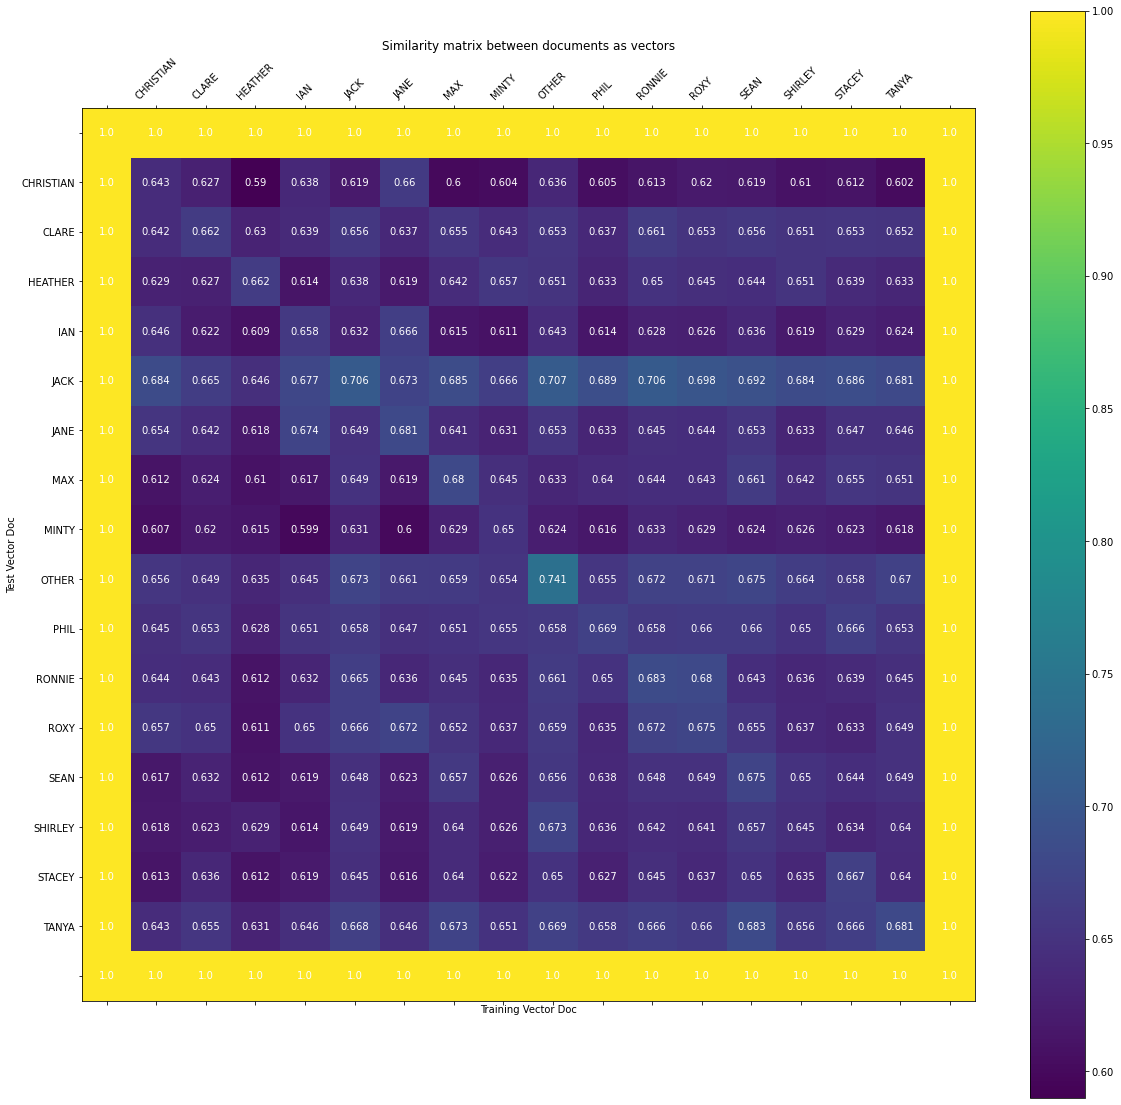

In [23]:
plot_heat_map_similarity(df)

In [24]:
### redo on all training data with the first 400 character lines used
train_character_docs = create_character_document_from_dataframe(all_train_data, max_line_count=400)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

training_corpus = [(name, pre_process(doc)) for name, doc in train_character_docs.items()]
train_labels = [name for name, doc in training_corpus]

corpusVectorizer = DictVectorizer()   # initialize a corpusVectorizor which will output sparse vectors from dicts
# Any matrix transformers (e.g. tf-idf transformers) should be initialized here
tfidf_transformer = TfidfTransformer()

training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)

# get the test data using 40 lines per character
test_character_docs = create_character_document_from_dataframe(test_data, max_line_count=40)
print('Num. Characters: ',len(test_character_docs.keys()),"\n")
total_words = 0
for name in test_character_docs.keys():
    print(name, 'Number of Words: ',len(test_character_docs[name].split()))
    total_words += len(test_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character) 
test_corpus = [(name, pre_process(doc)) for name, doc in test_character_docs.items()]
test_labels = [name for name, doc in test_corpus]


# Just transform the val_feature_matrix, don't fit
test_feature_matrix = create_document_matrix_from_corpus(test_corpus, fitting=False)


print("\n")
print("Evaluating...")
mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, test_feature_matrix, train_labels, test_labels)


lines per character {'SHIRLEY': 400, 'OTHER': 400, 'JACK': 400, 'RONNIE': 400, 'TANYA': 400, 'SEAN': 400, 'ROXY': 400, 'HEATHER': 400, 'MAX': 400, 'IAN': 400, 'JANE': 400, 'STACEY': 400, 'PHIL': 400, 'MINTY': 400, 'CHRISTIAN': 385, 'CLARE': 400}
Num. Characters:  16 

SHIRLEY Number of Words:  7259
OTHER Number of Words:  4445
JACK Number of Words:  7323
RONNIE Number of Words:  7265
TANYA Number of Words:  6865
SEAN Number of Words:  6834
ROXY Number of Words:  7066
HEATHER Number of Words:  7584
MAX Number of Words:  7811
IAN Number of Words:  7864
JANE Number of Words:  7151
STACEY Number of Words:  7314
PHIL Number of Words:  7663
MINTY Number of Words:  7670
CHRISTIAN Number of Words:  6998
CLARE Number of Words:  7859
total words 114971
lines per character {'SHIRLEY': 40, 'OTHER': 40, 'HEATHER': 40, 'PHIL': 40, 'SEAN': 40, 'TANYA': 40, 'MAX': 40, 'JACK': 40, 'IAN': 40, 'JANE': 40, 'STACEY': 40, 'ROXY': 40, 'RONNIE': 40, 'CHRISTIAN': 40, 'MINTY': 40, 'CLARE': 40}
Num. Characters: 

# APPENDIX
Below are some the experiments performed throughout the coursework. These are the intermediate results obtained (used to explain the thought process in the report).

The ones highlighed in green were the conbination that were finalised at each step. 

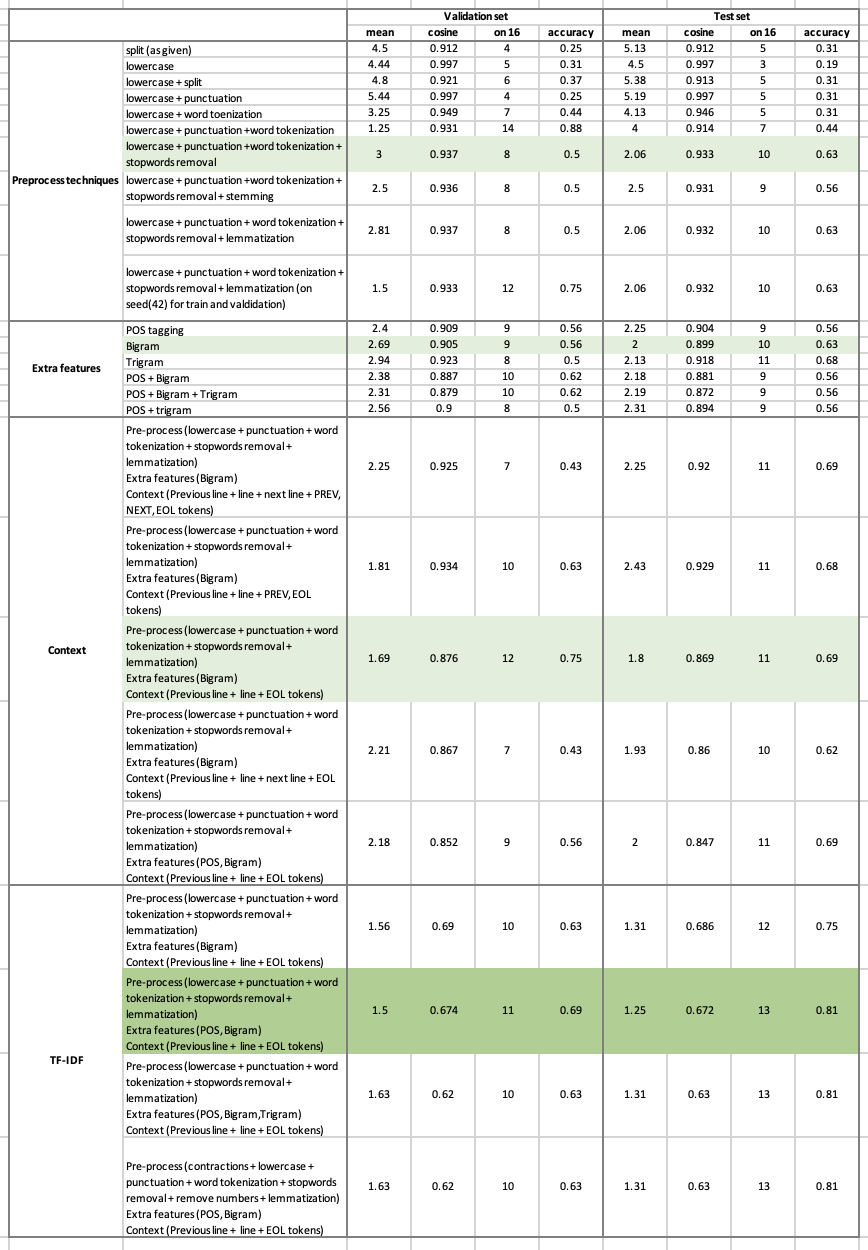

In [25]:
from IPython.display import Image
Image("Experiments.png")